# Symbolic computation using BDDs in AEON.py

This notebook shows examples of how to use binary decision diagrams (BDDs) available in the AEON.py tool. It assumes that you already know what BDDs are and their capabilities (i.e., we will not talk about BDDs, just the technical implementation of the library).

<p align="center">
  <img style="margin: 0 auto; display: block;" src="./img/bdd_example.png" />
</p>

Compared to other BDD libraries, here we do not have a single shared "BDD storage" or "BDD manager". Instead, **every BDD is a separate object**, which means it is easier to pass it around during asynchronous or parallel computing (i.e. more than one BDD operation can be running at the same time).

That being said, we still use a separate `BddVariableSet` to manage the mapping from *names* to the actual BDD variables, since names are not used as often and there is no need to keep them around in each BDD. This `BddVariableSet` object is also used to initially create BDD atoms, so it is probably the first thing that you'll need to setup before creating any BDDs. Furthermore, each BDD actually maintains the *total number* of variables that it supports (which is injected based on the `BddVariableSet`), and you **cannot mix BDDs with a different variable count**. So in practice, you should only combine BDDs created using the same `BddVariableSet`.

To begin, simply install AEON.py from PyPI (`pip install biodivine_aeon`) and import everything:

In [1]:
from biodivine_aeon import *

Detected IPython (`ZMQInteractiveShell`). Log level set to `LOG_ESSENTIAL`.


To create a `BddVariableSet`, you have two options: If you already know the number of variables (and their names), you can create it directly. Alternatively, you can create it gradually using a `BddVariableSetBuilder` while figuring out what variables to use.

In [2]:
# Create a BddVariableSet with 5 variables names a, b, c, d, e.
vars = BddVariableSet(["a", "b", "c", "d", "e"])
assert vars.variable_count() == 5
# To actually use the variables in the future, we have to use a `BddVariable` reference. 
# Here, v_a now contains a `BddVariable` reference. 
# In most methods, you can also use the variable names directly, but this is typically slowe
# because the names need to be resolved to IDs every time.
v_a = vars.find_variable("a")
v_c = vars.find_variable("c")

# For example, we can use the variable reference to create a literal: 
# That is, a BDD that corresponds either to function "a" or "!a".
positive_bdd_literal = vars.mk_literal(v_a, True)
negative_bdd_literal = vars.mk_literal(v_a, False)

# But we can also use names:
assert positive_bdd_literal == vars.mk_literal("a", True)

# We can also use the variable set to create constants:
bdd_true = vars.mk_const(True)

assert positive_bdd_literal.is_true() == False
assert bdd_true.is_true() == True  

# You can also create an "anonymous" variable set, where the names of the variables are 
# automatically set to "x_0", "x_1", ... , "x_{n-1}".
anonymous_vars = BddVariableSet(10)

# It is always possible to retrieve all variables valid in the set:
anonymous_ids = anonymous_vars.variable_ids()
anonymous_names = anonymous_vars.variable_names()

for i in range(len(anonymous_ids)):
    assert anonymous_names[i] == anonymous_vars.get_variable_name(anonymous_ids[i])

anonymous_names

['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9']

In some cases, you don't know the number (or names) of variables initially. For example, you want to have a function that creates the variables while reading the problem input, and saves the BDD variable references for future use:

In [3]:
builder = BddVariableSetBuilder()

# You can create variables one by one, and the builder will always give you the variable reference for later use.
v_first = builder.add("first")

# You can also create multiple variable at the same time if you want to.
created = builder.add_all(["second", "third", "fourth"])
v_third = created[1]

# In the end, you can just call build to turn the builder into a valid variable set.
four_vars = builder.build()
four_vars.variable_count()

4

Note that the library will automatically check whether you defined any duplicate variables. 

Furthermore, some special characters (like `!`, or other logical operators) cannot be used in a variable names. The reason for this is mainly that `BddVariableSet` can actually do quite a bit more than what we've shown already:

In [4]:
# If you have a formula that you want to quickly turn into a BDD, you can simply evaluate it as a string,
# as long as the variable names match the ones declared in your BddVariableSet.
formula = vars.eval_expression("a & (b => !c) & (d <=> (c & !a))")

# Furthermore, if you have a formula saved in CNF/DNF, you can also build it quite easily.
# Each element in the list is a dictionary containing the literals in the CNF/DNF clause. 
# Here, both `BddVariable` references and names are accepted.
conjunction = vars.mk_cnf([{v_a: True, "b": False}, {"c": False, "d": False}, {v_a: True, "c": True}])

# If you only want to create one clause, you can do that as well:
clause = vars.mk_conjunctive_clause({v_a: True, "b": False, "c": True})
clause.cardinality() # Get the number of valuations satisfied in this BDD.

4

To visually inspect the BDDs, you can use a simple `.dot` conversion. Here, we are using `graphviz` to actually show the pictures of the BDDs:

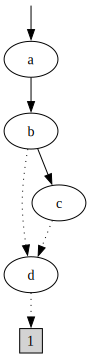

In [5]:
import graphviz

graphviz.Source(formula.to_dot())

For readability, the generated plot omits edges that lead to the `zero` terminal node, as these are easy to infer. To resolve the variable names, `Bdd` uses an internal reference to the `BddVariableSet` that created it (accessible through `Bdd.__ctx__()`).

In [6]:
assert formula.__ctx__() == vars

We can also convert BDDs back to Boolean expressions. However, we are not doing any special minification of the formula here, so the result could be larger than the original formula:

In [7]:
print(formula.to_expression())

(a & ((b & (!c & !d)) | (!b & !d)))


Alternatively, you can also convert the `Bdd` to a disjunctive or conjunctive normal form:

In [8]:
print("DNF")
for clause in formula.to_dnf():
    print(clause.items())
print("CNF")
for clause in formula.to_cnf():
    print(clause.items())

DNF
[(BddVariable(0), True), (BddVariable(1), True), (BddVariable(2), False), (BddVariable(3), False)]
[(BddVariable(0), True), (BddVariable(1), False), (BddVariable(3), False)]
CNF
[(BddVariable(0), True)]
[(BddVariable(0), False), (BddVariable(1), True), (BddVariable(3), False)]
[(BddVariable(0), False), (BddVariable(1), False), (BddVariable(2), True), (BddVariable(3), False)]
[(BddVariable(0), False), (BddVariable(1), False), (BddVariable(2), False)]


To actually manipulate the BDD, we can use normal logical operators, as well as more advanced relation operators (projection, selection, restriction, ...). However, note that because `and` and `or` are Python keywords, the actual methods are prefixed with `l_*` (logical operators) and `r_*` (relation operators) to clearly differentiate them from the built-in language features.

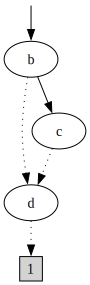

In [9]:
# Basic logical operators:

formula.l_and(conjunction)
formula.l_or(conjunction)
formula.l_xor(conjunction)
formula.l_imp(conjunction)
formula.l_iff(conjunction)
formula.l_and_not(conjunction)

# Projection, either using one variable, or a set of variables.
# Here, we have to use variable references instead of names though, 
# since the BDD object has no idea what the actual names of the variables are.
formula.r_exists([v_a, v_c])
formula.r_for_all([v_a, v_c])

# Projection "removes" the influence of a particular variable: F = F[a/0] | F[a/1]
graphviz.Source(formula.r_exists(v_a).to_dot())

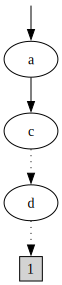

In [10]:
# Similarly, we can use selection to actually fix a variable to a specific value.
# Here, we have to also include the Boolean value to which we are fixing. 
# The argument is therefore a dictionary.
graphviz.Source(formula.r_select({ v_c: False }).to_dot())

Finally, to transfer and save BDDs, you can use a simple string and byte format that encodes the internal directed acyclic graph of the BDD:

In [11]:
assert Bdd(vars, formula.data_string()) == Bdd(vars, formula.data_bytes())

formula.data_string()

'|5,0,0|5,1,1|3,1,0|2,2,0|1,2,3|0,0,4|'

This representation does not preserve the underlying `BddVariableSet` of the `Bdd` (you'll have to save that separately). However, we can also use `pickle`. Here, the representation is not as efficient, but it preserves all the information in one data bundle:

In [12]:
import pickle
assert formula == pickle.loads(pickle.dumps(formula))

Now we've covered the basic portion of the BDD functionality. For more details, you can explore the API documentation of the `Bdd` class [here](https://biodivine.fi.muni.cz/docs/aeon-py/latest/).